# 数据预处理 

获取`kaggle`数据集

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import gc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 加载训练数据（假设train.parquet文件被分成了10个部分）
train_files = [f'../data/raw/train.parquet/partition_id={i}' for i in range(10)]
train_df_list = []

for file in train_files:
    df = pd.read_parquet(file)
    train_df_list.append(df)
    del df  # 释放内存
    gc.collect()

# 合并所有训练数据
train_df = pd.concat(train_df_list, ignore_index=True)
del train_df_list
gc.collect()

# 加载滞后响应变量数据
# lags_df = pd.read_parquet('lags.parquet')

0

In [4]:
print(len(train_df))
train_df.head

47127338


<bound method NDFrame.head of           date_id  time_id  symbol_id    weight  feature_00  feature_01  \
0               0        0          1  3.889038         NaN         NaN   
1               0        0          7  1.370613         NaN         NaN   
2               0        0          9  2.285698         NaN         NaN   
3               0        0         10  0.690606         NaN         NaN   
4               0        0         14  0.440570         NaN         NaN   
...           ...      ...        ...       ...         ...         ...   
47127333     1698      967         34  3.242493    2.525160   -0.721981   
47127334     1698      967         35  1.079139    1.857906   -0.790646   
47127335     1698      967         36  1.033172    2.515527   -0.672298   
47127336     1698      967         37  1.243116    2.663298   -0.889112   
47127337     1698      967         38  3.193685    2.728506   -0.745238   

          feature_02  feature_03  feature_04  feature_05  ...  featur

In [5]:
# 查看所有数值型特征的统计信息
train_df.describe()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
count,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.394529e+07,4.394529e+07,4.394529e+07,4.394529e+07,4.394529e+07,4.712734e+07,...,4.710730e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07,4.712734e+07
mean,1.005479e+03,4.687057e+02,1.810239e+01,2.009441e+00,5.738325e-01,1.019200e-02,5.731021e-01,5.727453e-01,-8.522313e-04,-3.837985e-02,...,-1.255890e-02,-1.545146e-03,-8.655997e-04,-1.419603e-04,-1.638009e-02,-1.244198e-02,-1.662422e-02,-2.140646e-03,1.476110e-03,-1.113618e-03
std,4.451819e+02,2.725187e+02,1.130165e+01,1.129388e+00,1.327413e+00,1.084941e+00,1.322870e+00,1.322849e+00,1.037188e+00,1.020120e+00,...,9.435918e-01,5.912108e-01,5.875515e-01,5.991787e-01,8.192309e-01,8.728399e-01,7.345458e-01,8.898516e-01,9.160423e-01,8.644118e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.499667e-01,-5.794129e+00,-5.741592e+00,-5.726010e+00,-5.601890e+00,-5.799880e+00,-2.535040e+01,...,-6.159515e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00,-5.000000e+00
25%,6.790000e+02,2.330000e+02,9.000000e+00,1.210248e+00,-3.325972e-01,-7.210978e-01,-3.298276e-01,-3.304725e-01,-7.067508e-01,-4.875799e-01,...,-3.039029e-01,-1.902501e-01,-1.637682e-01,-1.998778e-01,-3.100654e-01,-3.836545e-01,-2.254138e-01,-3.827613e-01,-4.197189e-01,-3.342880e-01
50%,1.060000e+03,4.670000e+02,1.700000e+01,1.749686e+00,4.057831e-01,7.341659e-03,4.070410e-01,4.063981e-01,2.275866e-03,-5.649172e-02,...,-1.948923e-01,-4.543308e-03,-2.383126e-02,-8.624472e-04,-2.575430e-02,-4.468977e-02,-9.661748e-03,-2.556645e-02,-3.917187e-02,-8.617128e-03
75%,1.376000e+03,7.010000e+02,2.800000e+01,2.525645e+00,1.261608e+00,7.293766e-01,1.258622e+00,1.258682e+00,7.037091e-01,3.906223e-01,...,4.861682e-02,1.819475e-01,1.273834e-01,1.990622e-01,2.611124e-01,3.132633e-01,2.005779e-01,3.343208e-01,3.553231e-01,3.112021e-01
max,1.698000e+03,9.670000e+02,3.800000e+01,1.024042e+01,6.477002e+00,6.292391e+00,6.490265e+00,6.695623e+00,6.164160e+00,3.572622e+01,...,2.574540e+02,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


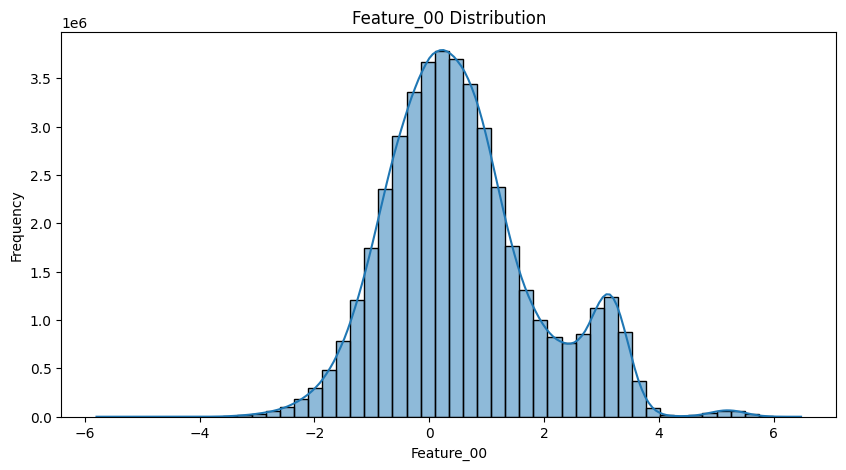

In [6]:
# feature_cols = [f'feature_{i:02d}' for i in range(79)]
# target = 'responder_6'

# 绘制feature_00的直方图
plt.figure(figsize=(10, 5))
sns.histplot(train_df['feature_21'], bins=50, kde=True)
plt.title('Feature_21 Distribution')
plt.xlabel('Feature_21')
plt.ylabel('Frequency')
plt.show()

In [7]:
# 计算每个列中的缺失值数量
missing_counts = train_df.isnull().sum()

# 计算每个列中的缺失值比例
missing_ratio = missing_counts / len(train_df)

# 创建一个DataFrame来展示缺失值信息
missing_df = pd.DataFrame({
    'MissingCount': missing_counts,
    'MissingRatio': missing_ratio
})

# 按照缺失值比例从高到低排序
missing_df = missing_df[missing_df['MissingCount'] > 0]  # 只保留有缺失值的列
missing_df = missing_df.sort_values(by='MissingRatio', ascending=False)

print(missing_df)


            MissingCount  MissingRatio
feature_21       8435985      0.179004
feature_26       8435985      0.179004
feature_27       8435985      0.179004
feature_31       8435985      0.179004
feature_39       4300649      0.091256
feature_42       4300649      0.091256
feature_53       4254098      0.090268
feature_50       4254098      0.090268
feature_00       3182052      0.067520
feature_02       3182052      0.067520
feature_03       3182052      0.067520
feature_04       3182052      0.067520
feature_01       3182052      0.067520
feature_15       1209299      0.025660
feature_41       1093012      0.023193
feature_44       1093012      0.023193
feature_55       1044898      0.022172
feature_52       1044898      0.022172
feature_73        483759      0.010265
feature_74        483759      0.010265
feature_33        478457      0.010152
feature_32        478457      0.010152
feature_58        478452      0.010152
feature_65        317163      0.006730
feature_66        317163 